In [2]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [3]:
%load_ext autoreload
%autoreload 2

# Mimic3-9K

> API details

In [4]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [5]:
from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [6]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path_model.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)

file_prefix = 'mimic3-9k'

data = path_data/(file_prefix+'.csv')
data_sample = path_data/(file_prefix+'-sample.csv')
dls_lm_path = path_model/f"{file_prefix}_dls_lm.pkl"
dls_lm_vocab_path = path_model/f"{file_prefix}_dls_lm_vocab.pkl"
lm_path = path_model/f"{file_prefix}_lm.pth"
lm_finetuned_path = path_model/f"{file_prefix}_lm_finetuned.pth"
dsets_clas_path = path_model/f"{file_prefix}_dset_clas.pkl"
dls_clas_path = path_model/f"{file_prefix}_dls_clas.pkl"
dls_clas_sample_path = path_model/f"{file_prefix}-sample_dls_clas.pkl"
clas_path = path_model/f"{file_prefix}_clas.pth"

print(f"{path = }")  
print(f"{path_data = }") 
print(f"{path_model = }") 
print(f"{file_prefix = }") 
print(f"{data = }")
print(f"{data_sample = }")  
print(f"{dls_lm_path = }") 
print(f"{dls_lm_vocab_path = }")
print(f"{lm_path = }")
print(f"{lm_finetuned_path = }")
print(f"{dsets_clas_path = }")
print(f"{dls_clas_path = }")
print(f"{dls_clas_sample_path = }")
print(f"{clas_path = }")

path = Path('/home/deb/xcube/nbs/examples/mimic')
path_data = Path('/home/deb/xcube/nbs/examples/mimic/data')
path_model = Path('/home/deb/xcube/nbs/examples/mimic/models')
file_prefix = 'mimic3-9k'
data = Path('/home/deb/xcube/nbs/examples/mimic/data/mimic3-9k.csv')
data_sample = Path('/home/deb/xcube/nbs/examples/mimic/data/mimic3-9k-sample.csv')
dls_lm_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_dls_lm.pkl')
dls_lm_vocab_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_dls_lm_vocab.pkl')
lm_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_lm.pth')
lm_finetuned_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_lm_finetuned.pth')
dsets_clas_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_dset_clas.pkl')
dls_clas_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k_dls_clas.pkl')
dls_clas_sample_path = Path('/home/deb/xcube/nbs/examples/mimic/models/mimic3-9k-sample_dls_clas.pkl')
clas_path

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [6]:
# !head -n 1 {data}

In [25]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [26]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [37]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [27]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [45]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,xxbos admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical,admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical for
1,outpatient he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at,he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at rehab


The length of our vocabulary is:

In [28]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [29]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [30]:
torch.save(dls_lm, dls_lm_path)
torch.save(dls_lm.vocab, dls_lm_vocab_path)

To load back the `dls_lm` later on:

In [44]:
dls_lm = torch.load(dls_lm_path)

## `Learner` for the Language Model Fine-Tuning:

In [7]:
dls_lm = torch.load(dls_lm_path)

In [8]:
dls_lm.bs

384

In [9]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

(0.10964782238006592,
 0.033113110810518265,
 0.0020892962347716093,
 0.02754228748381138)

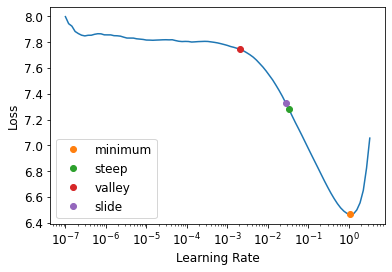

In [14]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [17]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.055411,2.889091,0.463165,17.976971,21:32


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [16]:
learn.save(file_prefix+'_lm')

Path('/home/deb/xcube/nbs/examples/mimic/lm.pth')

Let's now load back the `Learner`

In [10]:
learn = learn.load(file_prefix+'_lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [11]:
learn.validate()

(#3) [2.008333921432495,0.5733070969581604,7.450893402099609]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [15]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname=file_prefix+'_lm'))

In [21]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname=file_prefix/'_lm'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.700497,2.601790,0.498114,13.487859,21:50
1,2.532751,2.447730,0.516926,11.562066,21:53
2,2.438119,2.364874,0.527396,10.642694,21:45
3,2.373062,2.317114,0.533622,10.146353,21:37
4,2.315276,2.284130,0.538038,9.817142,21:30
5,2.294005,2.259134,0.541297,9.574790,21:33
6,2.244216,2.240372,0.544038,9.396826,21:33
7,2.236868,2.227880,0.546116,9.280175,21:30
8,2.209610,2.221307,0.547150,9.219376,21:31
9,2.166203,2.220918,0.547269,9.215789,21:37


Better model found at epoch 0 with valid_loss value: 2.601789951324463.
Better model found at epoch 1 with valid_loss value: 2.4477295875549316.
Better model found at epoch 2 with valid_loss value: 2.3648736476898193.
Better model found at epoch 3 with valid_loss value: 2.3171143531799316.
Better model found at epoch 4 with valid_loss value: 2.284130096435547.
Better model found at epoch 5 with valid_loss value: 2.2591335773468018.
Better model found at epoch 6 with valid_loss value: 2.2403719425201416.
Better model found at epoch 7 with valid_loss value: 2.2278804779052734.
Better model found at epoch 8 with valid_loss value: 2.2213072776794434.
Better model found at epoch 9 with valid_loss value: 2.2209181785583496.


Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [46]:
learn.save_encoder(file_prefix+'_lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

### Loading Raw Data

In [12]:
data

Path('/home/deb/xcube/nbs/examples/mimic/data/mimic3-9k.csv')

In [13]:
# !head -n 1 {data}

In [14]:
# data_sample.delete()

In [15]:
# !shuf -n 200000 {data} > {data_sample} 

In [16]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [24]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [12]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Sample a small fraction of the dataset to ensure quick iteration:

In [86]:
# df = df.sample(frac=0.1, random_state=89, ignore_index=True)
# len(df)

Let's now gather the labels from the 'labels' columns of the df:

In [25]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [26]:
len(lbl_freqs)

8922

Let's take a look at the most common labels:

In [93]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [27]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics 

#### Check #1: Number of instances (train/valid split)

In [59]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(48991, 15356)

#### Check #2: Avg number of instances per label

In [20]:
array(list(lbl_freqs.values())).mean()

95.12351490697154

#### Check #3: Plotting the label distribution

In [32]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(',')))

In [85]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [86]:
df_copy.head(2)

,text,labels,is_valid,label_count
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3


The average number of labels per instance is:

In [112]:
df_copy.label_count.mean()

5.385563363865518

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


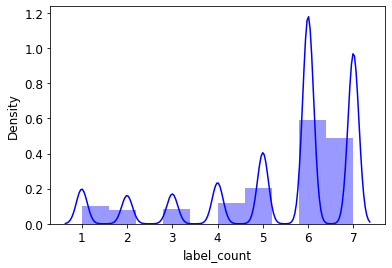

In [87]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [88]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [89]:
lbls_sorted[:20]

[('455619', 2258),
 ('455662', 2176),
 ('547041', 2160),
 ('516790', 1214),
 ('455712', 1203),
 ('455620', 1133),
 ('632786', 1132),
 ('632789', 1132),
 ('632785', 1030),
 ('632788', 1030),
 ('492255', 938),
 ('455014', 872),
 ('670034', 850),
 ('427871', 815),
 ('599701', 803),
 ('308331', 801),
 ('581325', 801),
 ('649272', 799),
 ('455704', 762),
 ('666760', 733)]

In [90]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#670091) ['455619','455662','547041','516790','455712','455620','632786','632789','632785','632788'...],
 (#670091) [2258,2176,2160,1214,1203,1133,1132,1132,1030,1030...])

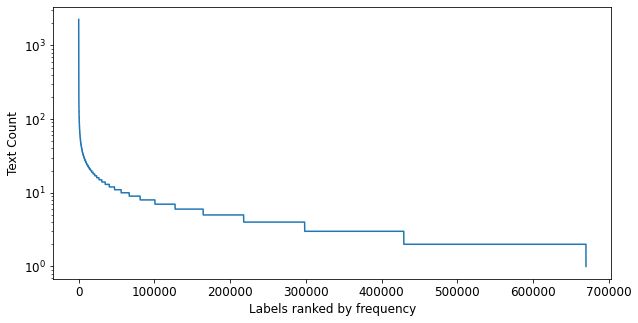

In [91]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Labels ranked by frequency')
ax.set_ylabel('Text Count')
ax.set_yscale('log');

#### Check #4: Computing the min label freq for each text

In [70]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [92]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [93]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [94]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

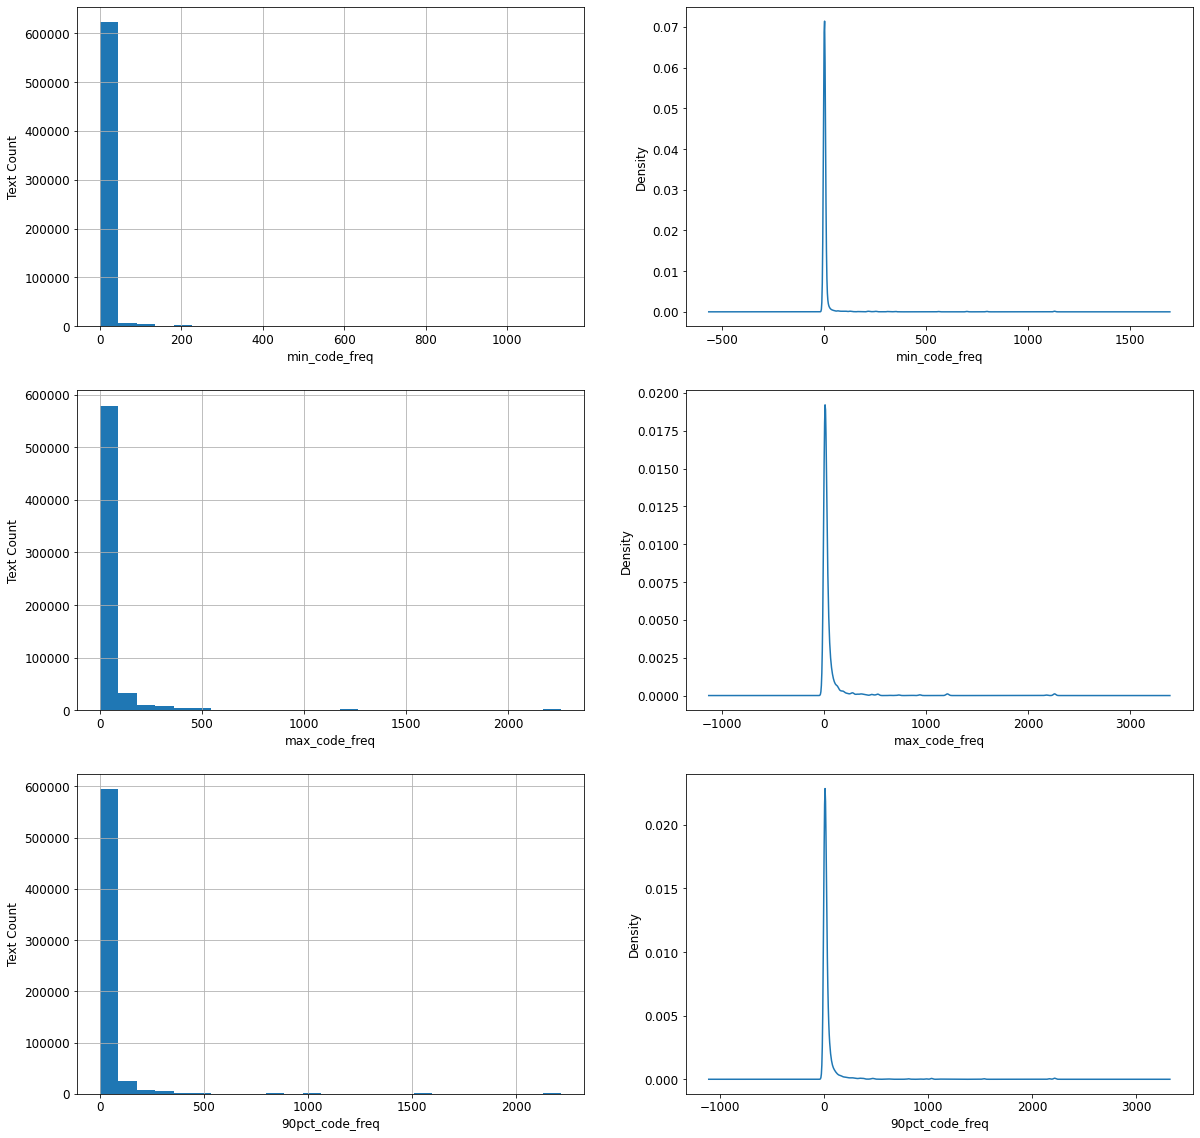

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [96]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [97]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [98]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [99]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

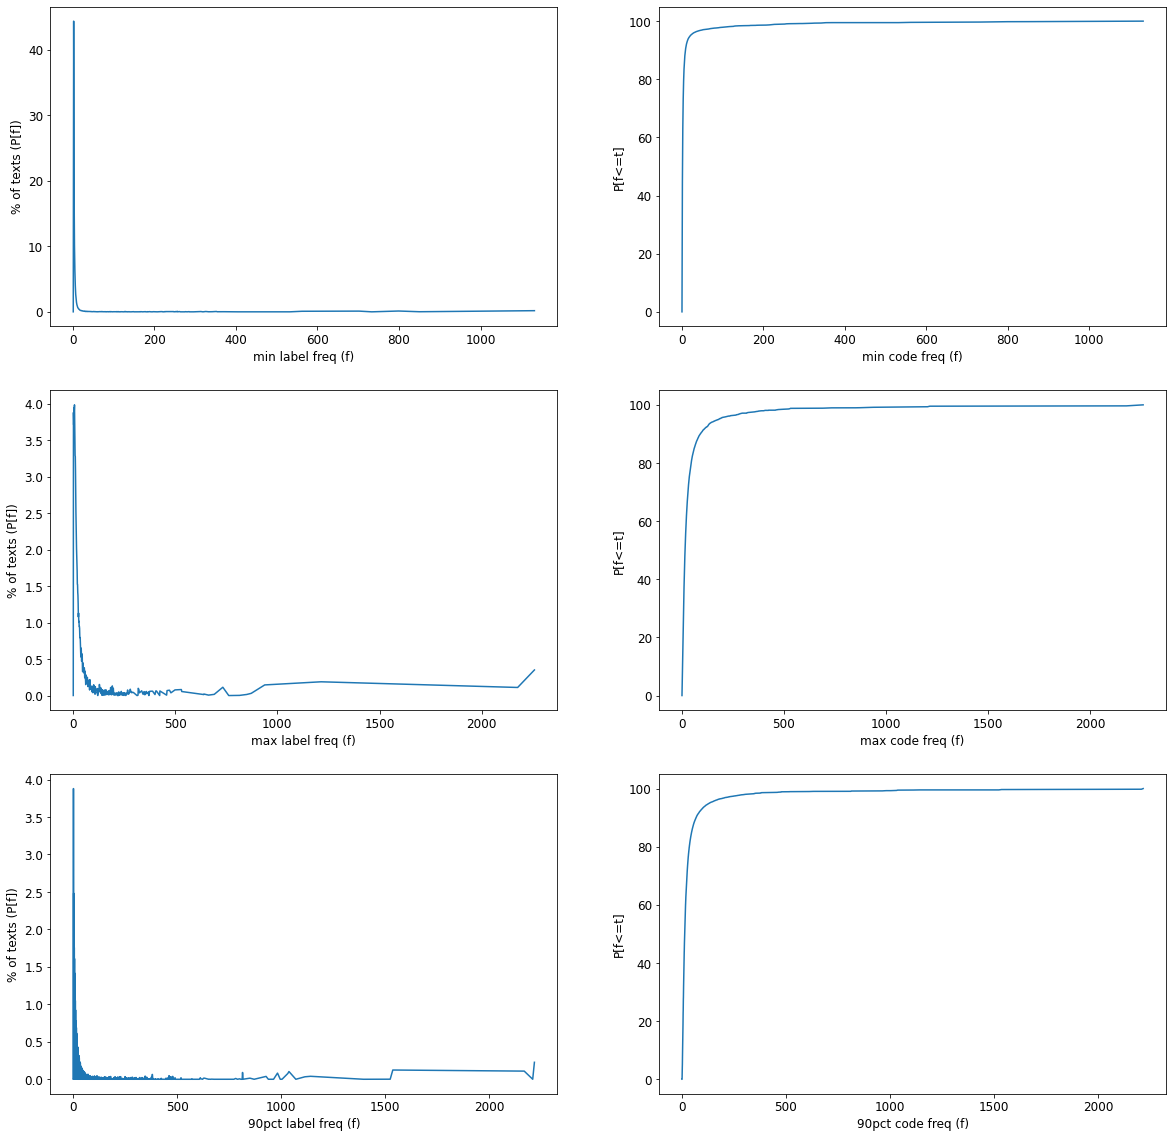

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [17]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [18]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [34]:
# lm_vocab = torch.load(dls_lm_vocab_path)
lm_vocab = torch.load(path/'dls_lm_vocab.pkl') # tmp

In [35]:
L(lm_vocab)

(#51928) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [36]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [37]:
dsets = Datasets(df, tfms, splits=splits)

Let's now check if our `Datasets` got created alright:

In [38]:
len(dsets.train), len(dsets.valid)

(49354, 3372)

In [26]:
x = dsets.train[0]

In [27]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic back pain she also has a history of a right lung cancer requiring right lobectomy in no metastasis was known and she has since recovered well and is considered cured social history unknown family history nc physical exam physical exam intubated non sedated received no paralytic medication no eye opening pupil rt mm lt mm both non reactive corneal bilat extends both ue to stim min withdrawal t

In [28]:
dsets.show(x)

xxbos admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic back pain she also has a history of a right lung cancer requiring right lobectomy in no metastasis was known and she has since recovered well and is considered cured social history unknown family history nc physical exam physical exam intubated non sedated received no paralytic medication no eye opening pupil rt mm lt mm both non reactive corneal bilat extends both ue to stim min withdrawal tri

Looks fine!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [40]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [41]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [42]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                        dl_type=dl_type,
                       before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [43]:
# torch.save(dls_clas, dls_clas_path)
torch.save(dls_clas, 'dls_clas.pkl') # tmp

Let's take a look at the data:

In [44]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date service cardiothoracic allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint doe fatigue and decreased exercise tolerance major surgical or invasive procedure redo sternotomy avr 21 mm company mosaic porcine valve mvr mm company mosaic porcine valve history of present illness yo female with prior cabg in since then she has developed increasing doe fatigue and decreased ability to tolerate activity echo revealed severe as and mr initially seen by dr last name stitle and now presents for surgical repair past medical history cabg x dr last name stitle cad as mr last name titles lipids htn gerd oncogenic osteomalacia lv diastolic dysfunction hereditary hypophosphatemic rickets bil hip surgeries with left thr prior bladder suspension prior tah prior cataract surgery social history retired homemaker never used tobacco denies etoh lives with husband family history not known physical exam,401.9;V43.64;V45.81;272.4;599.0;96.6;530.81;39.61;780.39;041.04;997.02;35.21;396.2;35.23;348.39;89.6;270.0
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,96.71;38.93;96.04;428.0;507.0;599.0;96.6;440.24;88.48;496;99.15;14.0;43.11;482.41;39.29;707.15;38.18;997.2;444.21;97.01;38.03
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,427.89;305.1;599.0;785.52;995.92;584.9;296.80;042;304.01;041.6;V12.04;008.45;332.0;038.8;348.39;304.21


## `Learner` for Multi-Label Classifier Fine-Tuning 

In [6]:
dls_clas = torch.load(dls_clas_path)
# dls_clas = torch.load(path/'dls_clas.pkl')

In [7]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=partial(PrecisionK, k=15)).to_fp16()

In [8]:
learn.model[-1]

LabelAttentionClassifier(
  (layers): LinBnDrop(
    (0): BatchNorm1d(8922, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.04000000000000001, inplace=False)
  )
  (emb_label): Embedding(8922, 400)
  (final_lin): Linear(in_features=400, out_features=8922, bias=True)
)

In [9]:
learn = learn.load_encoder(file_prefix+'_lm_finetuned')

## Fine-Tuning the Classifier 

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

(0.00043651582673192023,
 2.75422871709452e-06,
 0.0004786300996784121,
 0.02290867641568184)

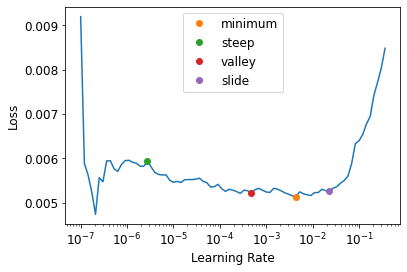

In [11]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [25]:
learn.fit_one_cycle(1, lr_max=0.109647, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.006730,0.008132,0.368545,26:19


In [10]:
learn.fit_one_cycle(1, lr_max=1e-1, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.006304,0.007090,0.475504,25:43


---

This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [12]:
learn.freeze_to(-2)

In [13]:
learn.fit_one_cycle(3, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.006021,0.006848,0.487999,33:38
1,0.005391,0.006627,0.499921,33:29
2,0.005479,0.006593,0.505101,33:27


Better model found at epoch 0 with valid_loss value: 0.0068475790321826935.
Better model found at epoch 1 with valid_loss value: 0.0066272784024477005.
Better model found at epoch 2 with valid_loss value: 0.006593428086489439.


In [12]:
learn.fit_one_cycle(3, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.005595,0.006888,0.482582,34:17
1,0.005658,0.006708,0.493179,34:03
2,0.005530,0.006631,0.502985,34:03
3,0.005401,0.006493,0.509193,34:26
4,0.005303,0.006412,0.515342,34:21
5,0.005235,0.006397,0.516766,34:21


Better model found at epoch 0 with valid_loss value: 0.006888470612466335.
Better model found at epoch 1 with valid_loss value: 0.006708190776407719.
Better model found at epoch 2 with valid_loss value: 0.006631003692746162.
Better model found at epoch 3 with valid_loss value: 0.00649256631731987.
Better model found at epoch 4 with valid_loss value: 0.006412094458937645.
Better model found at epoch 5 with valid_loss value: 0.0063971951603889465.


---

Start here:

In [11]:
learn.fit_one_cycle(6, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.005643,0.006492,0.507177,33:56


Better model found at epoch 0 with valid_loss value: 0.006492020096629858.


KeyboardInterrupt: 

Now we will unfreeze a bit more, recompute learning rate and continue training:

In [12]:
learn.freeze_to(-3)

In [13]:
learn.fit_one_cycle(10, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(fname=file_prefix+'_clas2'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.005224,0.006454,0.513464,43:57
1,0.005586,0.006621,0.506109,43:48
2,0.005637,0.006707,0.503974,43:53
3,0.005633,0.006621,0.500099,43:41


Better model found at epoch 0 with valid_loss value: 0.00645369291305542.


KeyboardInterrupt: 

Finally, we will unfreeze the whole model and perform training:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(fname=file_prefix+'_clas'))

To save the model:

In [11]:
learn.save(file_prefix+'_clas')

Path('models/clas.pth')

To load the model:

In [9]:
learn = learn.load(file_prefix+'_clas')
learn.validate()

(#2) [0.007090234663337469,0.4755041518386714]

To plot the train/valid loss and the metric over the course of training:

In [ ]:
learn.recorder.plot_loss()

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));